# Model SBC Report

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from pathlib import Path
from time import time
from typing import List

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg

from src.loggers import set_console_handler_level
from src.managers.model_cache_managers import Pymc3ModelCacheManager
from src.modeling import pymc3_analysis as pmanal
from src.modeling import simulation_based_calibration_helpers as sbc
from src.project_enums import ModelFitMethod

In [3]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

set_console_handler_level(logging.WARNING)
pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file
- `FIT_METHOD`: model fitting method used for this SBC

## Setup

### Papermill parameters

In [4]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""
FIT_METHOD_STR = ""

In [5]:
# Parameters
MODEL_NAME = "sp2-default"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/sp2-default_MCMC_collated-posterior-summaries.pkl"
)
NUM_SIMULATIONS = 500
CONFIG_PATH = "models/model-configs.yaml"
FIT_METHOD_STR = "MCMC"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [6]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

Confirm that there is a positive number of simulations.

In [7]:
assert NUM_SIMULATIONS > 0

In [8]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)

## Read in all results

In [9]:
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
μ_α,μ_α,0.064,0.099,-0.011,0.250,0.048,0.037,6.0,28.0,2.39,0.882026,sim_id_0000,False
"α[0,0]",α,0.470,0.100,0.373,0.632,0.050,0.038,5.0,15.0,3.23,1.273675,sim_id_0000,False
"α[0,1]",α,0.921,0.085,0.829,1.068,0.042,0.032,4.0,12.0,3.55,1.778736,sim_id_0000,False
"α[0,2]",α,0.769,0.085,0.676,0.916,0.042,0.032,4.0,12.0,3.60,1.629343,sim_id_0000,False
"α[0,3]",α,-0.310,0.101,-0.409,-0.147,0.050,0.038,4.0,15.0,3.33,0.490961,sim_id_0000,False


## Analysis

### ADVI approximation histories

In [10]:
if FIT_METHOD is ModelFitMethod.ADVI:
    advi_histories: List[np.ndarray] = []

    for dir in sbc_results_dir.iterdir():
        if not dir.is_dir():
            continue

        cache_manager = Pymc3ModelCacheManager(name=MODEL_NAME, root_cache_dir=dir)
        if cache_manager.advi_cache_exists():
            _, advi_approx = cache_manager.get_advi_cache()
            advi_histories.append(advi_approx.hist)
    n_sims_advi_hist = min(NUM_SIMULATIONS, 5)
    sample_hist_idxs = np.random.choice(
        list(range(len(advi_histories))), size=n_sims_advi_hist, replace=False
    )

    def make_hist_df(sim_idx: int, hist_list: List[np.ndarray]) -> pd.DataFrame:
        df = pd.DataFrame({"sim_idx": sim_idx, "loss": hist_list[sim_idx].flatten()})
        df["step"] = np.arange(df.shape[0])
        return df

    sampled_advi_histories = pd.concat(
        [make_hist_df(i, advi_histories) for i in sample_hist_idxs]
    ).reset_index(drop=True)

    (
        gg.ggplot(
            sampled_advi_histories,
            gg.aes(x="step", y="np.log(loss)", color="factor(sim_idx)"),
        )
        + gg.geom_line(alpha=0.5)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
        + gg.theme(legend_position=(0.8, 0.5))
        + gg.labs(y="log loss", color="sim. idx.")
    ).draw()
    plt.show()

### MCMC diagnostics

In [ ]:
class IncompleteCachedResultsWarning(UserWarning):
    pass


all_sbc_perm_dirs = list(sbc_results_dir.iterdir())

for perm_dir in np.random.choice(
    all_sbc_perm_dirs, size=min([5, len(all_sbc_perm_dirs)]), replace=False
):
    print(perm_dir.name)
    print("-" * 30)
    sbc_fm = sbc.SBCFileManager(perm_dir)
    if sbc_fm.all_data_exists():
        sbc_res = sbc_fm.get_sbc_results()
        _ = pmanal.describe_mcmc(sbc_res.inference_obj)
    else:
        warnings.warn(
            "Cannot find all components of the SBC results.",
            IncompleteCachedResultsWarning,
        )

### Estimate accuracy

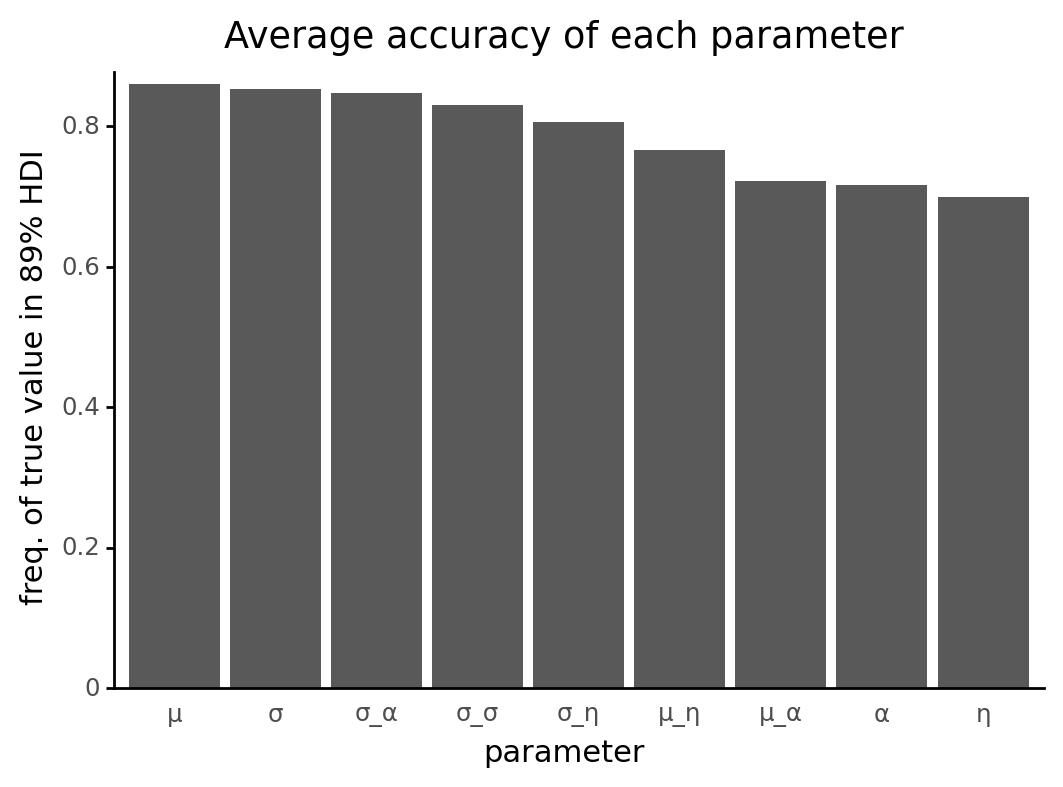

<ggplot: (8772526513616)>

In [12]:
accuracy_per_parameter = (
    simulation_posteriors_df.copy()
    .groupby(["parameter_name"])["within_hdi"]
    .mean()
    .reset_index(drop=False)
    .sort_values("within_hdi", ascending=False)
    .reset_index(drop=True)
)

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

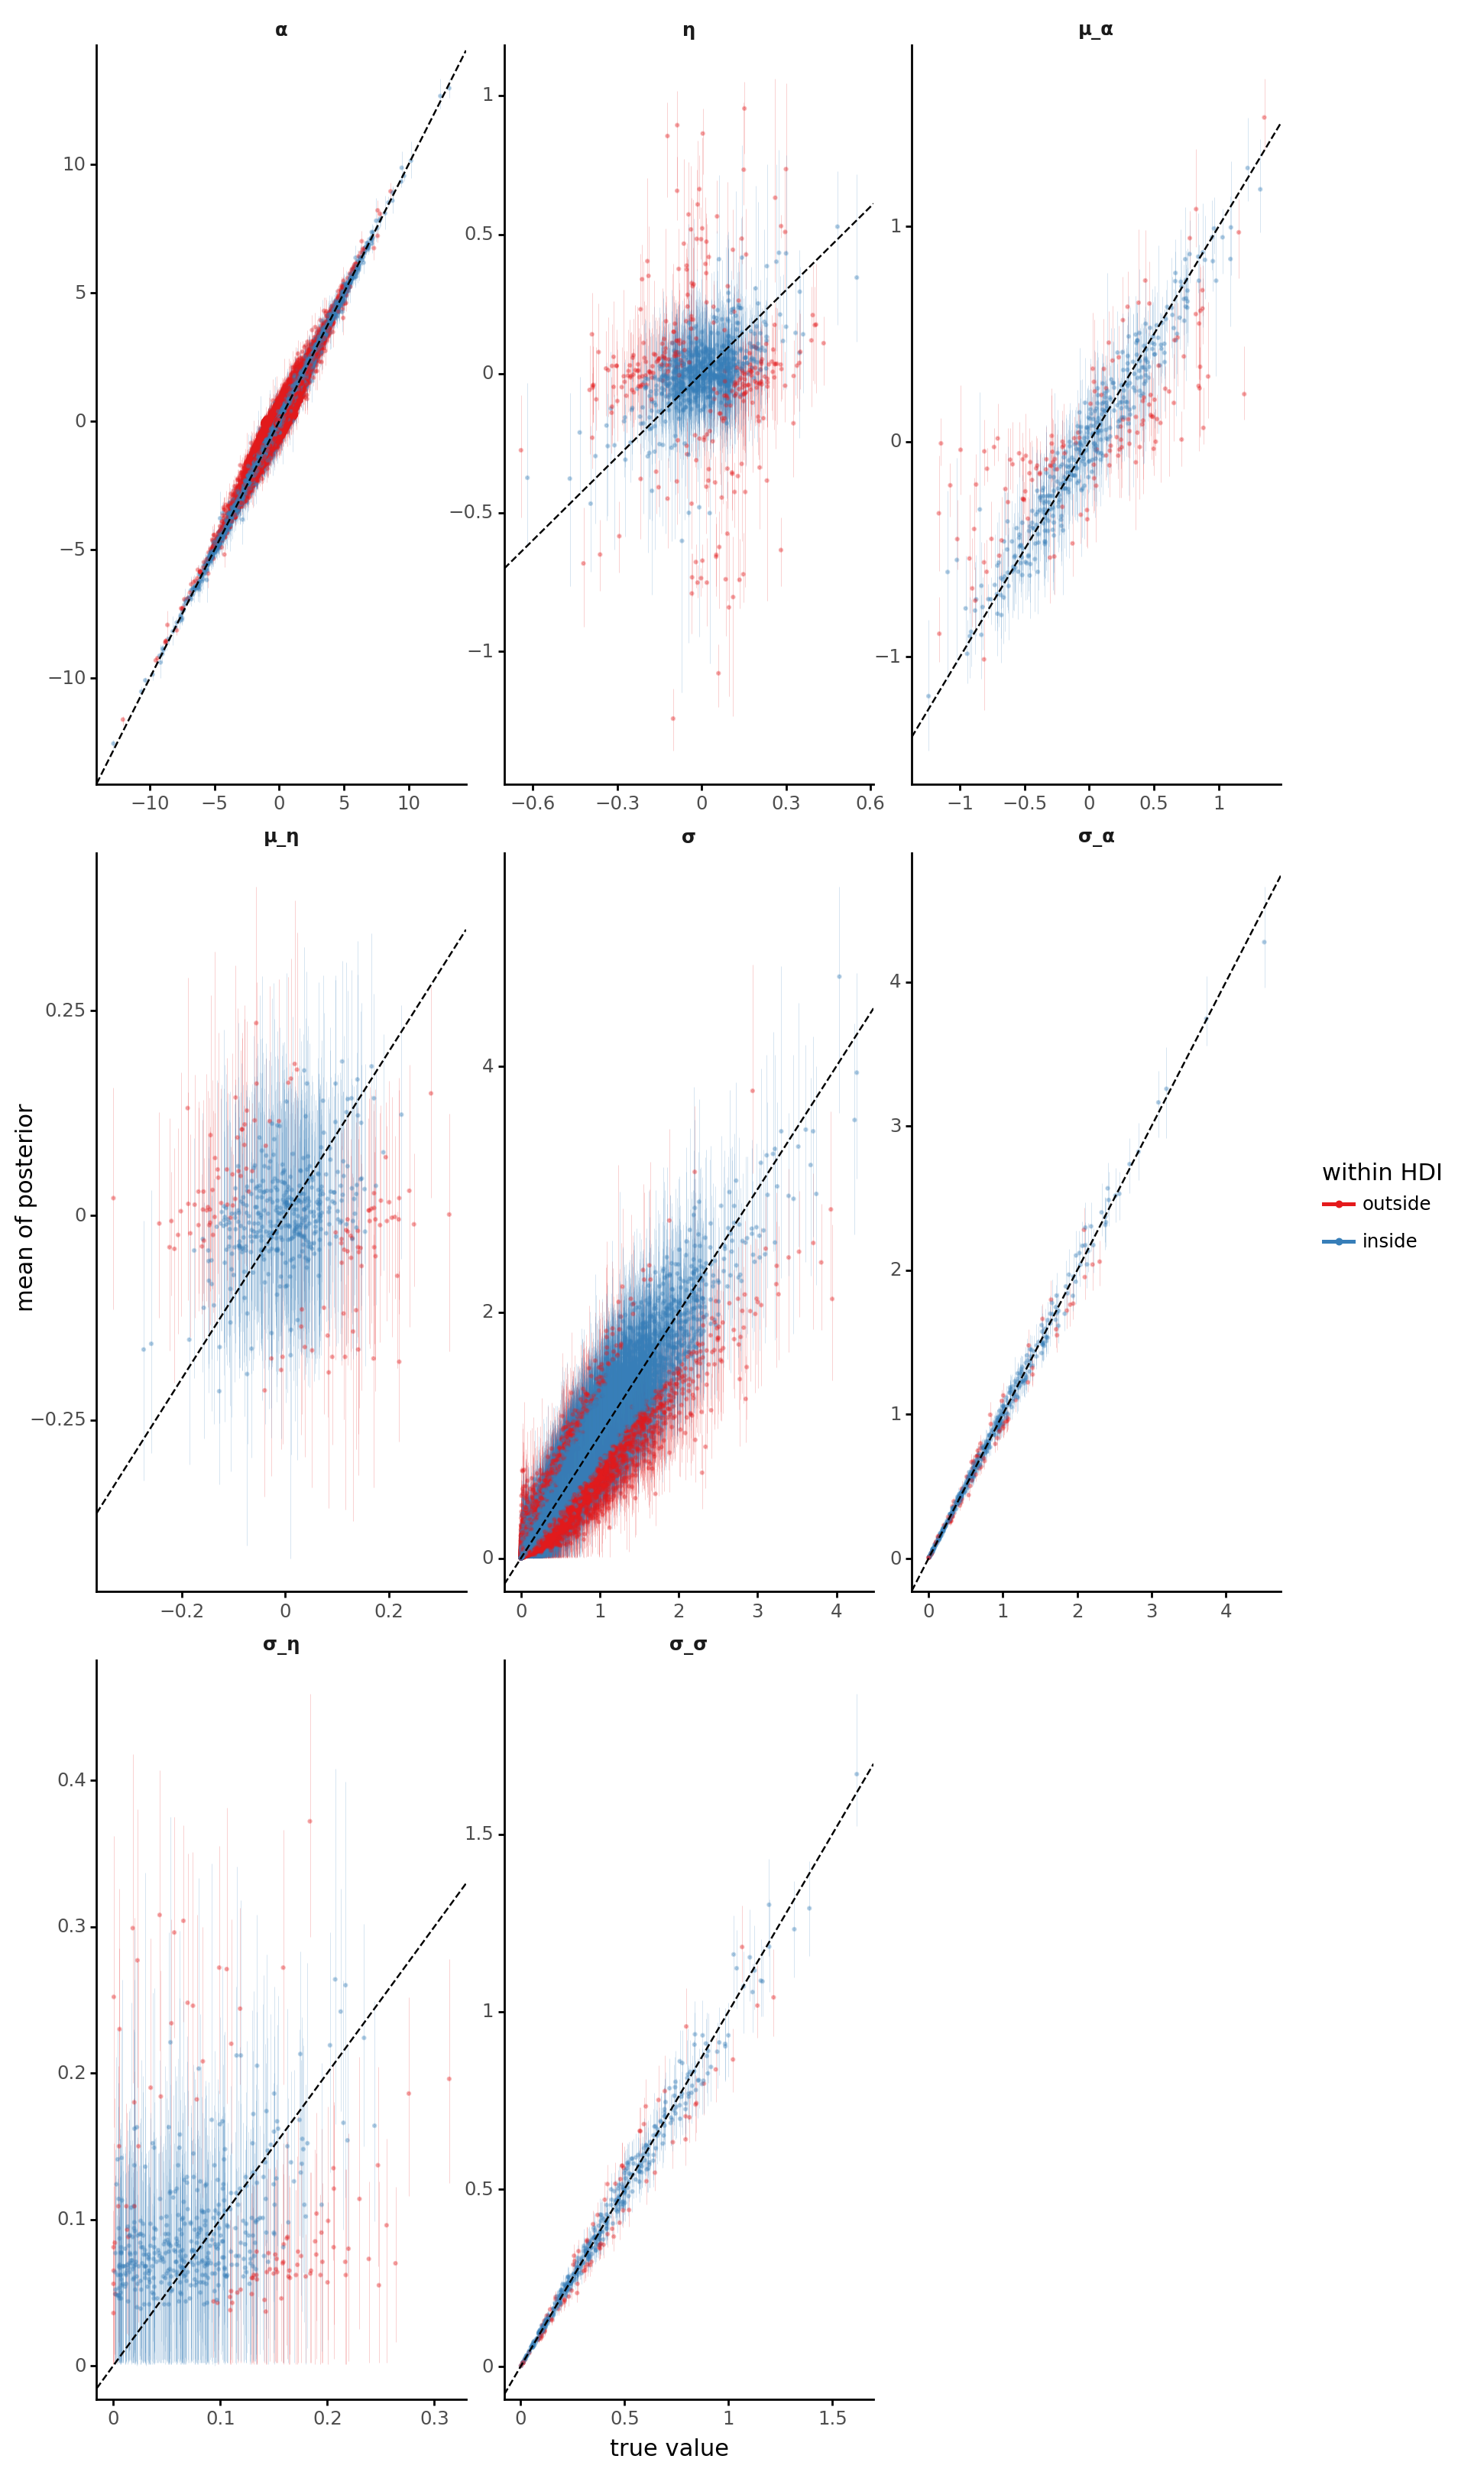

<ggplot: (8772530136546)>

In [13]:
hdi_low, hdi_high = pmanal.get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


(
    gg.ggplot(
        filter_uninsteresting_parameters(simulation_posteriors_df),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

### SBC Uniformity Test

In [14]:
sbc_analyzer = sbc.SBCAnalysis(
    root_dir=sbc_results_dir, pattern="sbc-perm", n_simulations=NUM_SIMULATIONS
)

In [15]:
K_DRAWS = 100
sbc_uniformity_test = sbc_analyzer.uniformity_test(k_draws=K_DRAWS)
sbc_uniformity_test.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 199, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/xarray/backends/lru_cache.py", line 53, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm499/inference-data.netcdf',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-0d44e6e9d722>", line 2, in <module>
    sbc_uniformity_test = sbc_analyzer.uniformity_test(k_dra

TypeError: object of type 'NoneType' has no len()

In [ ]:
sbc_uniformity_test.parameter.unique().tolist()

In [ ]:
var_names = sbc_uniformity_test.parameter.unique().tolist()
var_names = [v for v in var_names if "μ" not in v]
for v in np.random.choice(var_names, size=min((10, len(var_names))), replace=False):
    ax = sbc_analyzer.plot_uniformity(
        sbc_uniformity_test.query(f"parameter == '{v}'"), k_draws=K_DRAWS
    )
    ax.set_title(v)
    plt.show()

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m